## CSE 544: Probability & Statistics for Data Science – Spring 2025  
**Instructor:** Anshul Gandhi  
**Project Type:** Mini Group Project – Semester-end submission

### Group Information  
**Group Submitter:** Abhishek Kohli (SBU ID: 116652139)  
**Group Members:**  
- Dhruv Kunjadiya (SBU ID: 116248529)  
- Divyaank Tiwari (SBU ID: 115765038)  
- Harshil Snehalkumar Sanghvi (SBU ID: 115381322)

**Data Split Used:** `split_03.csv`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, ks_2samp, ttest_ind
import numpy as np
import itertools as it

In [2]:
df = pd.read_csv('split_03.csv')

In [3]:
df.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach
1,43eaa7e045b3e8a3157e5e38a31696c9,2022-04-16,2022-04-17,ATL,BOS,HA0QA0MQ,PT2H35M,0,False,False,...,1650243840,2022-04-17T21:04:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9300,947,coach
2,dc2eda19b0499170f1f7f8c5a179ac07,2022-04-16,2022-04-17,ATL,CLT,M0AHZNN1,PT1H22M,0,False,False,...,1650238620,2022-04-17T19:37:00.000-04:00,CLT,ATL,American Airlines,AA,Canadian Regional Jet 700,4920,228,coach
3,4cf3ae8112e707a55d98c1fcd488c7b4,2022-04-16,2022-04-17,ATL,DEN,QA0NA0MQ,PT3H17M,0,False,False,...,1650244500,2022-04-17T19:15:00.000-06:00,DEN,ATL,Delta,DL,Airbus A321,11820,1207,coach
4,ba84d3c3f0a54f0016d23774182b1150,2022-04-16,2022-04-17,ATL,DEN,QA0NA0MQ,PT3H20M,0,False,False,...,1650258000,2022-04-17T23:00:00.000-06:00,DEN,ATL,Delta,DL,Airbus A321,12000,1207,coach


In [4]:
# consider only nonstop flights
nonstop_df = df[df['isNonStop']]

In [5]:
# create new dataset listing distance, duration, airline, and airplane type for all non-stop flights
cols = {
    'totalTravelDistance': 'Distance',
    'travelDuration': 'Duration',
    'segmentsAirlineName': 'Airline',
    'segmentsEquipmentDescription' : 'Airplane Type'
}
nonstop_df = nonstop_df.rename(columns=cols)
# keep only the columns we want
nonstop_df = nonstop_df[cols.values()]


In [6]:
import re

def parse_duration(s):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', s)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours + minutes / 60
    return None

nonstop_df['Duration (Hrs.)'] = nonstop_df['Duration'].apply(parse_duration)

In [7]:
nonstop_df['Speed'] = nonstop_df['Distance'] / nonstop_df['Duration (Hrs.)']

In [8]:
nonstop_df.dropna(subset=['Distance', 'Duration (Hrs.)', 'Speed'], inplace=True)

In [9]:
nonstop_df.drop_duplicates(inplace=True)

In [10]:
nonstop_df_final = nonstop_df[['Distance', 'Duration (Hrs.)', 'Airline', 'Airplane Type', 'Speed']]

In [11]:
nonstop_df_final.head()

,Distance,Duration (Hrs.),Airline,Airplane Type,Speed
0,947.0,2.566667,Delta,Airbus A321,368.961039
1,947.0,2.583333,Delta,Airbus A321,366.580645
2,228.0,1.366667,American Airlines,Canadian Regional Jet 700,166.829268
3,1207.0,3.283333,Delta,Airbus A321,367.614213
4,1207.0,3.333333,Delta,Airbus A321,362.100000


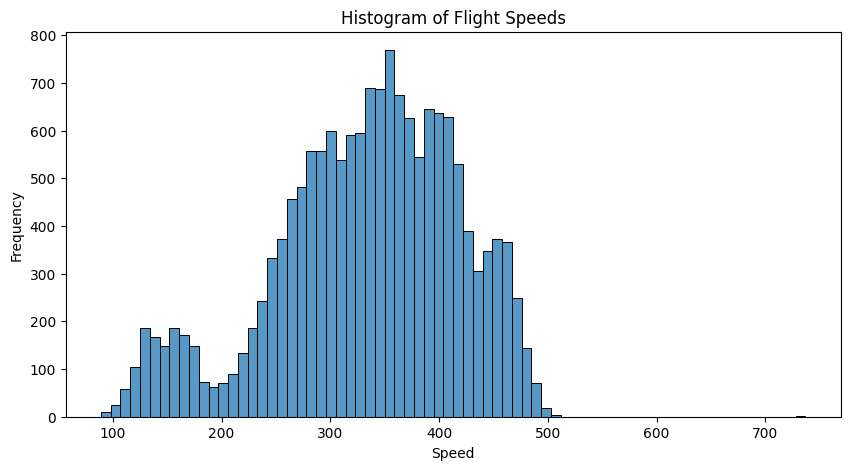

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(nonstop_df_final['Speed'])
plt.title("Histogram of Flight Speeds")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.show()

It seems that overall distribution is approximately bell shaped though slightly left-skewed; most speeds fall between 250-450 mph with clear peak around 350 mph which is typical of commerical jet speeds. There is visible secondary bump at lower speeds around 150 mph which might be corresponding to regional or short-haul aircrafts. A few extreme values (beyond 600/700 mph) seems like outliers/anomalies.

In [13]:
speeds_737_800 = nonstop_df_final[nonstop_df_final['Airplane Type'] == 'Boeing 737-800']['Speed']

mean_737_800 = speeds_737_800.mean()
std_737_800 = speeds_737_800.std()

ks_stat, p_value = kstest(speeds_737_800, 'norm', args=(mean_737_800, std_737_800))
print(f"Boeing 737-800 Speed KS Test: Statistic={ks_stat}, p-value={p_value}")

# check if the distribution of speeds for Boeing 737-800 is normal
if p_value > 0.05:
    print("The distribution of speeds for Boeing 737-800 is likely normal.")
else:
    print("The distribution of speeds for Boeing 737-800 is likely not normal.")

Boeing 737-800 Speed KS Test: Statistic=0.05106522438183814, p-value=2.301840507596522e-05
The distribution of speeds for Boeing 737-800 is likely not normal.


In [14]:
speeds_delta = nonstop_df_final[nonstop_df_final['Airline'] == 'Delta']['Speed']
mean_delta = speeds_delta.mean()
std_delta = speeds_delta.std()

ks_stat, p_value = kstest(speeds_delta, 'norm', args=(mean_delta, std_delta))
print(f"Delta Airlines Speed KS Test: Statistic={ks_stat}, p-value={p_value}")

# check if the distribution of speeds for Delta Airlines is normal
if p_value > 0.05:
    print("The distribution of speeds for Delta Airlines is likely normal.")
else:
    print("The distribution of speeds for Delta Airlines is likely not normal.")

Delta Airlines Speed KS Test: Statistic=0.03487566528042031, p-value=0.0004429914034818441
The distribution of speeds for Delta Airlines is likely not normal.


In [15]:
def permutation_test(sample1, sample2, num_permutations=10000):
    combined = np.concatenate([sample1, sample2])
    n1 = len(sample1)
    n2 = len(sample2)
    observed_diff = abs(sample1.mean() - sample2.mean())
    count = 0

    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_sample1 = combined[:n1]
        new_sample2 = combined[n1:]
        new_diff = abs(new_sample1.mean() - new_sample2.mean())
        if new_diff > observed_diff: # using strictly greater than because professor used strictly greater than in class
            count += 1

    return count / num_permutations

In [16]:
speeds_737_900 = nonstop_df_final[nonstop_df_final['Airplane Type'] == 'Boeing 737-900']['Speed']

ks_stat, p_value = ks_2samp(speeds_737_800, speeds_737_900)
print(f"KS Test between Boeing 737-800 and 737-900: Statistic={ks_stat}, p-value={p_value}")

# check if the distributions of speeds for Boeing 737-800 and 737-900 are the same
if p_value > 0.05:
    print("The distributions of speeds for Boeing 737-800 and 737-900 are likely the same.")
else:
    print("The distributions of speeds for Boeing 737-800 and 737-900 are likely not the same.")

KS Test between Boeing 737-800 and 737-900: Statistic=0.16661265337075373, p-value=1.4799226656423737e-18
The distributions of speeds for Boeing 737-800 and 737-900 are likely not the same.


In [17]:
permutation_test_737_800_737_900 = permutation_test(speeds_737_800, speeds_737_900)
print(f"Permutation Test between Boeing 737-800 and 737-900: p-value={permutation_test_737_800_737_900}")

# check if the distributions of speeds for Boeing 737-800 and 737-900 are the same
if permutation_test_737_800_737_900 > 0.05:
    print("The distributions of speeds for Boeing 737-800 and 737-900 are likely the same.")
else:
    print("The distributions of speeds for Boeing 737-800 and 737-900 are likely not the same.")

Permutation Test between Boeing 737-800 and 737-900: p-value=0.0
The distributions of speeds for Boeing 737-800 and 737-900 are likely not the same.


In [18]:
speeds_aa = nonstop_df_final[nonstop_df_final['Airline'] == 'American Airlines']['Speed']

ks_stat, p_value = ks_2samp(speeds_delta, speeds_aa)
print(f"KS Test between Delta Airlines and American Airlines: Statistic={ks_stat}, p-value={p_value}")

# check if the distributions of speeds for Delta Airlines and American Airlines are the same
if p_value > 0.05:
    print("The distributions of speeds for Delta Airlines and American Airlines are likely the same.")
else:
    print("The distributions of speeds for Delta Airlines and American Airlines are likely not the same.")

KS Test between Delta Airlines and American Airlines: Statistic=0.10721917486475127, p-value=2.9089221191262646e-19
The distributions of speeds for Delta Airlines and American Airlines are likely not the same.


In [19]:
permutation_test_delta_aa = permutation_test(speeds_delta, speeds_aa)
print(f"Permutation Test between Delta Airlines and American Airlines: p-value={permutation_test_delta_aa}")

# check if the distributions of speeds for Delta Airlines and American Airlines are the same
if permutation_test_delta_aa > 0.05:
    print("The distributions of speeds for Delta Airlines and American Airlines are likely the same.")
else:
    print("The distributions of speeds for Delta Airlines and American Airlines are likely not the same.")

Permutation Test between Delta Airlines and American Airlines: p-value=0.0
The distributions of speeds for Delta Airlines and American Airlines are likely not the same.


In [20]:
def walds_test(mean1, mean2, var1, var2, n1, n2):
    # using sample mean as estimator
    w_stat = abs(mean1 - mean2) / np.sqrt((var1 / n1) + (var2 / n2))
    p_val = 2 * (1 - norm.cdf(w_stat))
    return w_stat, p_val

In [21]:
def z_test(mean1, mean2, var1, var2, n1, n2):
    # treating sample variance as true variance
    z_stat = abs(mean1 - mean2) / np.sqrt((var1 / n1) + (var2 / n2))
    p_val = 2 * (1 - norm.cdf(z_stat))
    return z_stat, p_val

In [22]:
def perform_all_tests(sample1, sample2):
    mean1 = sample1.mean()
    mean2 = sample2.mean()
    var1 = sample1.var()
    var2 = sample2.var()
    n1 = len(sample1)
    n2 = len(sample2)

    wald_stat, wald_p_val = walds_test(mean1, mean2, var1, var2, n1, n2)
    z_stat, z_p_val = z_test(mean1, mean2, var1, var2, n1, n2)
    t_stat, t_p_val = ttest_ind(sample1, sample2, equal_var=False)

    return {
        'Walds Test': (wald_stat, wald_p_val),
        'Z Test': (z_stat, z_p_val),
        'T Test': (abs(t_stat), t_p_val) # using absolute value for consistency
    } 

In [23]:
def compare_groups(df, column, groups):
    for g1, g2 in it.combinations(groups, 2):
        speeds1 = df[df[column] == g1]['Speed']
        speeds2 = df[df[column] == g2]['Speed']
        test_results = perform_all_tests(speeds1, speeds2)

        print(f"------ {g1} vs {g2} ------")
        for test_name, (stat, p_val) in test_results.items():
            print(f"{test_name}: Statistic={stat}, p-value={p_val}")
            if p_val > 0.05:
                print(f"The distributions of speeds for {g1} and {g2} are likely the same.")
            else:
                print(f"The distributions of speeds for {g1} and {g2} are likely not the same.")
        print()

In [24]:
airplane_types = ['Boeing 737-800', 'Boeing 737-900', 'Airbus A321', 'Airbus A320']
compare_groups(nonstop_df_final, 'Airplane Type', airplane_types)

------ Boeing 737-800 vs Boeing 737-900 ------
Walds Test: Statistic=6.378521562502757, p-value=1.7880563696337504e-10
The distributions of speeds for Boeing 737-800 and Boeing 737-900 are likely not the same.
Z Test: Statistic=6.378521562502757, p-value=1.7880563696337504e-10
The distributions of speeds for Boeing 737-800 and Boeing 737-900 are likely not the same.
T Test: Statistic=6.378521562502757, p-value=2.2179431511534902e-10
The distributions of speeds for Boeing 737-800 and Boeing 737-900 are likely not the same.

------ Boeing 737-800 vs Airbus A321 ------
Walds Test: Statistic=9.179236812153048, p-value=0.0
The distributions of speeds for Boeing 737-800 and Airbus A321 are likely not the same.
Z Test: Statistic=9.179236812153048, p-value=0.0
The distributions of speeds for Boeing 737-800 and Airbus A321 are likely not the same.
T Test: Statistic=9.179236812153048, p-value=6.82027159333922e-20
The distributions of speeds for Boeing 737-800 and Airbus A321 are likely not the s

In [25]:
airlines = ['American Airlines', 'Delta', 'Alaska Airlines', 'JetBlue Airways']
compare_groups(nonstop_df_final, 'Airline', airlines)

------ American Airlines vs Delta ------
Walds Test: Statistic=4.6097820274273005, p-value=4.030913722585794e-06
The distributions of speeds for American Airlines and Delta are likely not the same.
Z Test: Statistic=4.6097820274273005, p-value=4.030913722585794e-06
The distributions of speeds for American Airlines and Delta are likely not the same.
T Test: Statistic=4.609782027427301, p-value=4.099190101146101e-06
The distributions of speeds for American Airlines and Delta are likely not the same.

------ American Airlines vs Alaska Airlines ------
Walds Test: Statistic=13.032633681955415, p-value=0.0
The distributions of speeds for American Airlines and Alaska Airlines are likely not the same.
Z Test: Statistic=13.032633681955415, p-value=0.0
The distributions of speeds for American Airlines and Alaska Airlines are likely not the same.
T Test: Statistic=13.032633681955415, p-value=8.926371351006344e-33
The distributions of speeds for American Airlines and Alaska Airlines are likely no

In [26]:
def label_route(distance):
    if distance < 1000:
        return 'Short'
    elif distance < 2200:
        return 'Medium'
    else:
        return 'Long'
    
nonstop_df_final['Route Type'] = nonstop_df_final['Distance'].apply(label_route)

In [27]:
route_types = nonstop_df_final['Route Type'].unique()
compare_groups(nonstop_df_final, 'Route Type', route_types)

------ Short vs Medium ------
Walds Test: Statistic=128.96043492473555, p-value=0.0
The distributions of speeds for Short and Medium are likely not the same.
Z Test: Statistic=128.96043492473555, p-value=0.0
The distributions of speeds for Short and Medium are likely not the same.
T Test: Statistic=128.96043492473558, p-value=0.0
The distributions of speeds for Short and Medium are likely not the same.

------ Short vs Long ------
Walds Test: Statistic=162.76526278072564, p-value=0.0
The distributions of speeds for Short and Long are likely not the same.
Z Test: Statistic=162.76526278072564, p-value=0.0
The distributions of speeds for Short and Long are likely not the same.
T Test: Statistic=162.76526278072566, p-value=0.0
The distributions of speeds for Short and Long are likely not the same.

------ Medium vs Long ------
Walds Test: Statistic=51.662021186645546, p-value=0.0
The distributions of speeds for Medium and Long are likely not the same.
Z Test: Statistic=51.662021186645546, 